In [1]:
%load_ext autoreload
%autoreload 2
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import odc.geo.xr  # noqa
import pandas as pd
import xarray as xr
from odc.geo.xr import xr_reproject
from scipy.stats import kendalltau

from ocr import catalog

warnings.filterwarnings('ignore')

In [2]:
states = gpd.read_file('s3://carbonplan-risks/shapefiles/cb_2018_us_state_20m.zip')
ca = states[states['STUSPS'].isin(['CA'])]
census_tracts = gpd.read_parquet(
    's3://carbonplan-ocr/input/fire-risk/vector/aggregated_regions/tracts/tracts.parquet'
)
ca_census_tracts = census_tracts.loc[census_tracts.geometry.intersects(ca.unary_union)]

<Axes: >

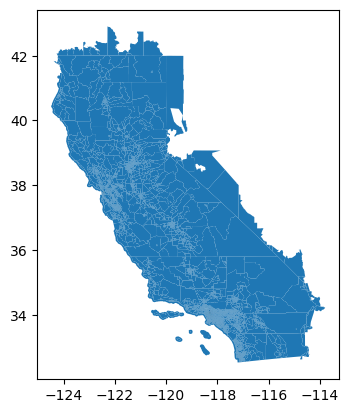

In [3]:
ca_census_tracts.plot()

In [5]:
rebuild_ca_buildings = True
version = 'v0.7.0'
if rebuild_ca_buildings:
    building_file = gpd.read_parquet(
        f's3://carbonplan-ocr/output/fire-risk/vector/production/{version}/geoparquet/buildings.parquet'
    )
    ca = ca.to_crs(building_file.crs)
    # find all rows
    ca_buildings = building_file.loc[building_file.geometry.intersects(ca.unary_union)]
    ca_buildings.to_parquet(
        f's3://carbonplan-risks/shapefiles/buildings_california_{version}.parquet'
    )
else:
    ca_buildings = gpd.read_parquet(
        f's3://carbonplan-risks/shapefiles/buildings_california_{version}.parquet'
    )

In [9]:
building_file = None

In [6]:
# load in cal fire hazard layer

In [7]:
fpath = 's3://carbonplan-ocr/input/fire-risk/tensor/calfire-fhsz/calfire-risk-raster.tif'
ds = xr.open_dataset(fpath, engine='rasterio')
ds = ds.odc.assign_crs('epsg:3310')
ds_reprojected = xr_reproject(ds, how='EPSG:4326')

In [8]:
# get building coords
coords = [(geom.x, geom.y) for geom in ca_buildings.geometry.centroid]
coords = np.array(coords)

In [10]:
# extract hazard for buildings
building_hazard = ds_reprojected.sel(
    latitude=xr.DataArray(coords[:, 1], dims='building'),
    longitude=xr.DataArray(coords[:, 0], dims='building'),
    method='nearest',
)

In [11]:
# cast all nulls to zeros. areas with zero are considered not at risk in the cal fire approach
# and by casting them to zero we make them have a lower value than the non-zero values which
# prepares the data for a ranked test like kendall-tau
# TODO: this still retains a few hundred -3 values
building_hazard = xr.where(building_hazard.band_data.isnull(), 0, building_hazard.band_data)

In [12]:
ca_buildings['cal-fire-hazard-zone'] = building_hazard.values[0]

In [13]:
ca_buildings_in_census_tracts = gpd.sjoin(ca_buildings, ca_census_tracts[['GEOID', 'geometry']])

In [14]:
ca_buildings_in_census_tracts.to_parquet(
    f's3://carbonplan-risks/shapefiles/buildings_tracts_california_{version}.parquet'
)

In [15]:
def apply_kendall_tau(x, y, variant):
    # confirm we want to use b variant
    tau, p_value = kendalltau(x, y, variant=variant)
    return pd.Series({f'tau_{variant}': tau, f'p_value_{variant}': p_value})

In [22]:
ca_buildings_in_census_tracts = ca_buildings_in_census_tracts.rename(
    {'GEOID_right': 'GEOID'}, axis=1
)

In [36]:
ds_name_dict = {'CarbonPlan': 'wind_risk_2011', 'Scott (2024)': 'USFS_RPS'}

In [47]:
tract_performance_stats = ca_census_tracts[['GEOID', 'geometry']]
for dataset_name, variable_name in ds_name_dict.items():
    for variant in ['b', 'c']:
        print(variant)
        new_df = ca_buildings_in_census_tracts.groupby('GEOID').apply(
            lambda g: apply_kendall_tau(g[variable_name], g['cal-fire-hazard-zone'], variant)
        )
        new_df.columns = [f'{dataset_name} {column_name}' for column_name in new_df.columns]
        tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID')
    # new_df = ca_buildings_in_census_tracts.groupby('GEOID').apply(
    #     lambda g: apply_kendall_tau(g[variable_name], g['cal-fire-hazard-zone'], 'c')
    # )
    # new_df.columns = [f'{dataset_name} {column_name}' for column_name in new_df.columns]

    # tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID')

tract_performance_stats.to_parquet(
    f's3://carbonplan-risks/shapefiles/california_tract_stats_{version}.parquet'
)

b
c
b
c


In [48]:
tract_performance_stats

,GEOID,geometry,CarbonPlan tau_b,CarbonPlan p_value_b,CarbonPlan tau_c,CarbonPlan p_value_c,Scott (2024) tau_b,Scott (2024) p_value_b,Scott (2024) tau_c,Scott (2024) p_value_c
0,04015955001,"POLYGON ((-114.63672 34.88911, -114.63665 34.8...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,04015952005,"POLYGON ((-114.56534 34.78623, -114.56444 34.7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,04015955002,"POLYGON ((-114.63027 34.86599, -114.63018 34.8...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,04012020602,"POLYGON ((-114.73122 33.30404, -114.7299 33.30...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,04012940300,"POLYGON ((-114.53587 33.92871, -114.53583 33.9...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9124,41015950401,"POLYGON ((-124.26902 42.05491, -124.26812 42.0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9125,41035970600,"POLYGON ((-121.55227 42.02414, -121.55134 42.0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9126,41035970300,"POLYGON ((-122.28997 42.12716, -122.28988 42.1...",-0.759555,0.023625,-0.9375,0.023625,-0.759555,0.023625,-0.9375,0.023625
9127,41037960200,"POLYGON ((-120.88107 42.33879, -120.88106 42.3...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
tract_tau = ca_buildings_in_census_tracts.groupby('GEOID').apply(
    lambda g: apply_kendall_tau(g['USFS_RPS'], g['cal-fire-hazard-zone'], 'b')
)
tract_performance_stats = ca_census_tracts[['GEOID', 'geometry']].merge(tract_tau, on='GEOID')
new_df = ca_buildings_in_census_tracts.groupby('GEOID').apply(
    lambda g: apply_kendall_tau(g['USFS_RPS'], g['cal-fire-hazard-zone'], 'c')
)
tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID')
# tract_performance_stats.to_parquet(
#     f's3://carbonplan-risks/shapefiles/california_tract_stats_{version}.parquet'
# )

In [24]:
variable_name_dict = {
    'tau_b': "Kendall's Tau (b-variant) of RPS",
    'tau_c': "Kendall's Tau (c-variant) of RPS",
    'bias': 'RPS bias (CP - WRC)',
    'corr': 'Correlation',
    'median_wind_risk_2011': 'CP median RPS',
    'median_USFS_RPS': 'WRC median RPS',
    'mean_wind_risk_2011': 'CP mean RPS',
    'mean_USFS_RPS': 'WRC mean RPS',
    'normalized_bias': 'RPS normalized bias\n((CP - WRC)/WRC)',
}
var_lims = {
    'tau_b': [-1, 1],
    'tau_c': [-1, 1],
    'bias': [-0.1, 0.1],
    'normalized_bias': [-1, 1],
    'corr': [-1, 1],
}

cmaps = {
    'tau_b': 'PRGn',
    'tau_c': 'PRGn',
    'bias': 'RdBu_r',
    'normalized_bias': 'RdBu_r',
    'corr': 'PRGn',
}

Text(0.5, 1.0, "Kendall's Tau with respect to Cal-Fire's hazard map")

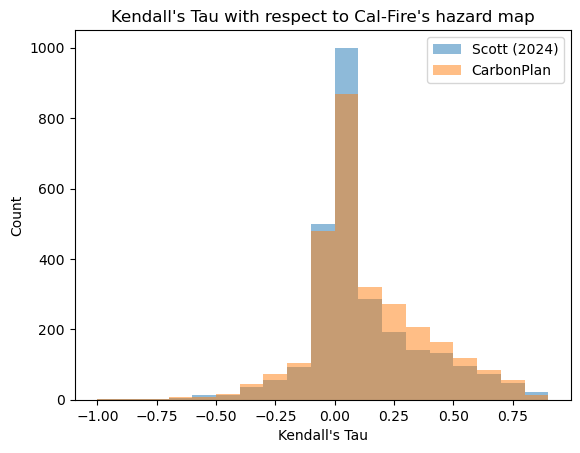

In [67]:
plt.hist(
    tract_performance_stats['Scott (2024) tau_c'].values,
    bins=np.arange(-1, 1, 0.1),
    label='Scott (2024)',
    alpha=0.5,
)
plt.hist(
    tract_performance_stats['CarbonPlan tau_c'].values,
    bins=np.arange(-1, 1, 0.1),
    label='CarbonPlan',
    alpha=0.5,
)
plt.legend()
plt.xlabel("Kendall's Tau")
plt.ylabel('Count')
plt.title("Kendall's Tau with respect to Cal-Fire's hazard map")

In [63]:
tract_performance_stats['Scott (2024) tau_c'].mean()

np.float64(0.11574955152724876)

In [64]:
tract_performance_stats['CarbonPlan tau_c'].mean()

np.float64(0.13292430013609377)

(array([  0.,   0.,   3.,   4.,   7.,  31.,  48., 106., 136., 405., 484.,
        414., 323., 294., 207., 191., 124.,  56.,   7.]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01]),
 <BarContainer object of 19 artists>)

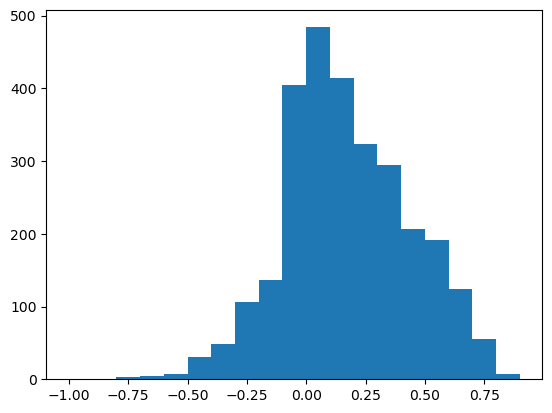

In [25]:
plt.hist(tract_performance_stats['tau_b'].values, bins=np.arange(-1, 1, 0.1))

(array([  3.,   1.,   3.,   7.,   7.,  17.,  45.,  72., 105., 480., 869.,
        319., 273., 206., 163., 118.,  85.,  55.,  12.]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01]),
 <BarContainer object of 19 artists>)

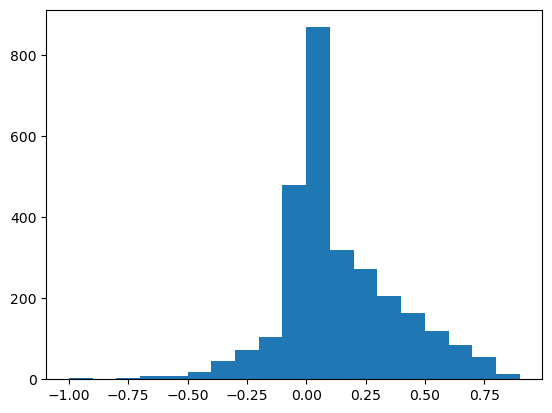

In [26]:
plt.hist(tract_performance_stats['tau_c'].values, bins=np.arange(-1, 1, 0.1))

(array([   3.,    3.,    2.,    4.,   12.,   14.,   37.,   56.,   94.,
         499., 1000.,  285.,  193.,  142.,  134.,   97.,   73.,   48.,
          23.]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01]),
 <BarContainer object of 19 artists>)

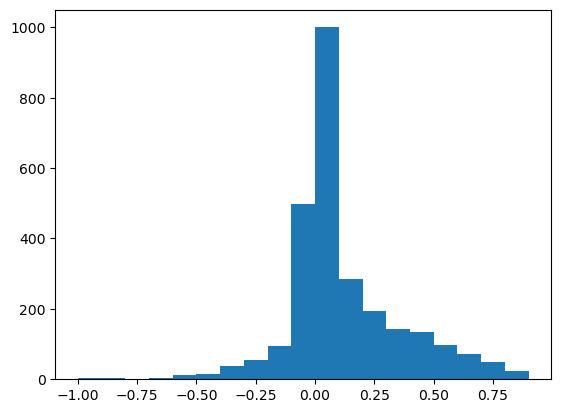

In [33]:
plt.hist(tract_performance_stats['tau_c'].values, bins=np.arange(-1, 1, 0.1))

In [51]:
tract_performance_stats

,GEOID,geometry,CarbonPlan tau_b,CarbonPlan p_value_b,CarbonPlan tau_c,CarbonPlan p_value_c,Scott (2024) tau_b,Scott (2024) p_value_b,Scott (2024) tau_c,Scott (2024) p_value_c
0,04015955001,"POLYGON ((-114.63672 34.88911, -114.63665 34.8...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,04015952005,"POLYGON ((-114.56534 34.78623, -114.56444 34.7...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,04015955002,"POLYGON ((-114.63027 34.86599, -114.63018 34.8...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,04012020602,"POLYGON ((-114.73122 33.30404, -114.7299 33.30...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,04012940300,"POLYGON ((-114.53587 33.92871, -114.53583 33.9...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9124,41015950401,"POLYGON ((-124.26902 42.05491, -124.26812 42.0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9125,41035970600,"POLYGON ((-121.55227 42.02414, -121.55134 42.0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9126,41035970300,"POLYGON ((-122.28997 42.12716, -122.28988 42.1...",-0.759555,0.023625,-0.9375,0.023625,-0.759555,0.023625,-0.9375,0.023625
9127,41037960200,"POLYGON ((-120.88107 42.33879, -120.88106 42.3...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
ds_name_dict.keys()

dict_keys(['CarbonPlan', 'Scott (2024)'])

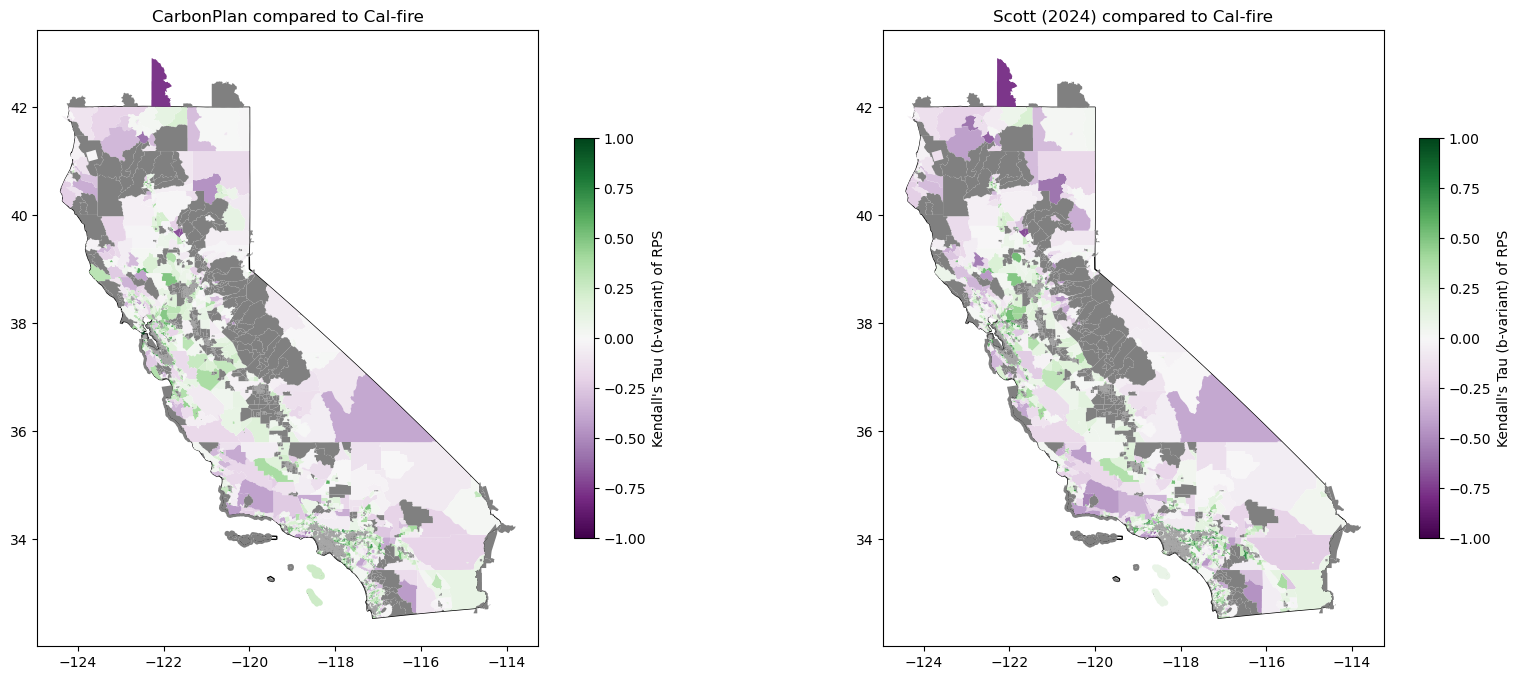

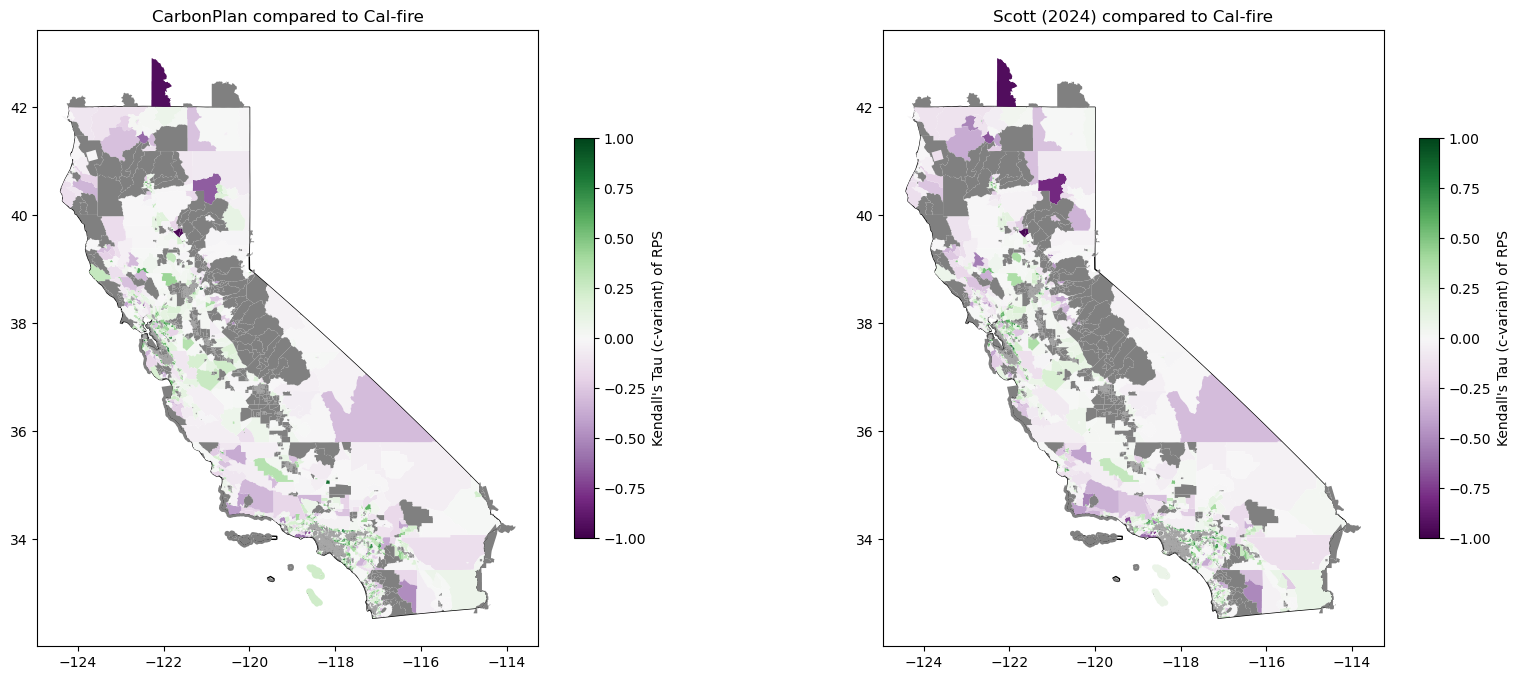

In [70]:
for variable in ['tau_b', 'tau_c']:
    fig, axarr = plt.subplots(ncols=2, figsize=(20, 8))
    for i, dataset_name in enumerate(ds_name_dict.keys()):
        ca.plot(ax=axarr[i], color='white', edgecolor='black')
        ax = tract_performance_stats.plot(
            ax=axarr[i],
            column=f'{dataset_name} {variable}',
            vmin=var_lims[variable][0],
            vmax=var_lims[variable][1],
            legend=True,
            cmap=cmaps[variable],
            legend_kwds={'shrink': 0.65, 'label': variable_name_dict[variable]},
        )
        tract_performance_stats[
            tract_performance_stats[f'{dataset_name} {variable}'].isnull()
        ].plot(ax=axarr[i], color='grey')
        axarr[i].set_title(f'{dataset_name} compared to Cal-fire')

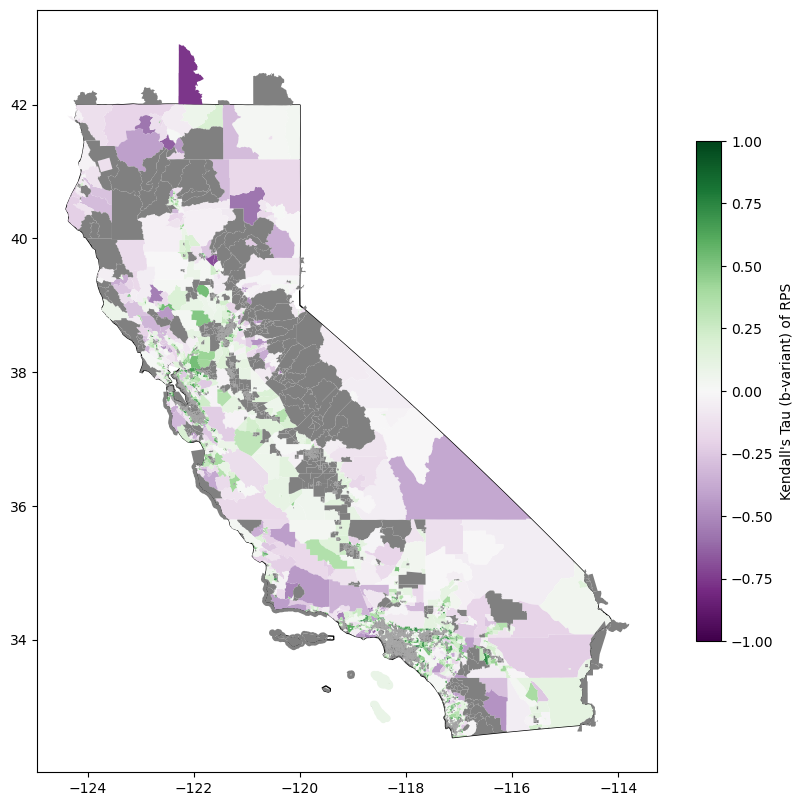

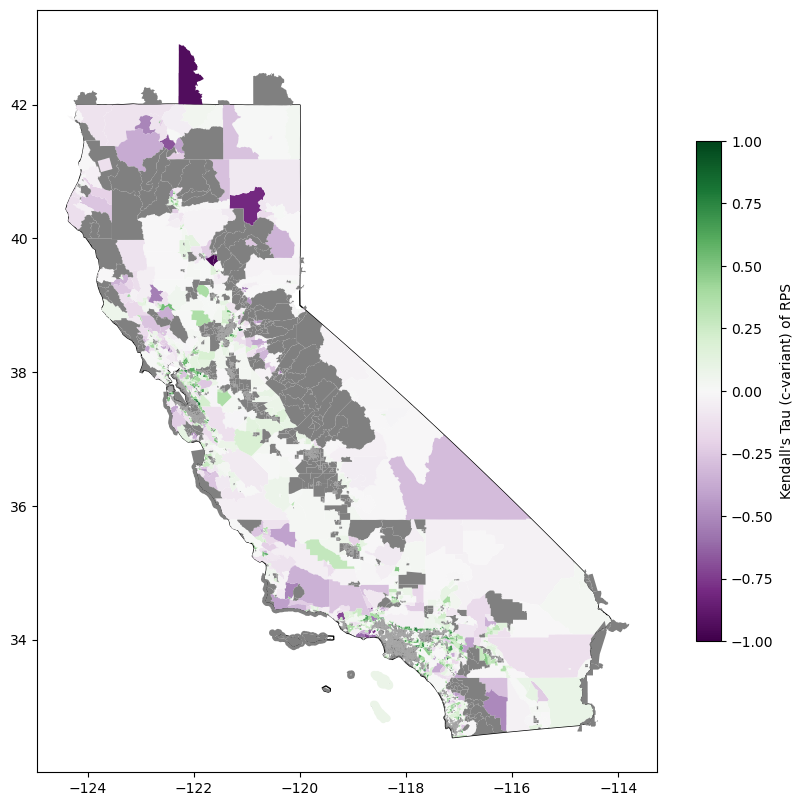

In [31]:
for variable in ['tau_b', 'tau_c']:
    fig, axarr = plt.subplots(figsize=(10, 10))
    ca.plot(ax=axarr, color='white', edgecolor='black')
    ax = tract_performance_stats.plot(
        ax=axarr,
        column=variable,
        vmin=var_lims[variable][0],
        vmax=var_lims[variable][1],
        legend=True,
        cmap=cmaps[variable],
        legend_kwds={'shrink': 0.65, 'label': variable_name_dict[variable]},
    )
    tract_performance_stats[tract_performance_stats['tau_b'].isnull()].plot(ax=axarr, color='grey')

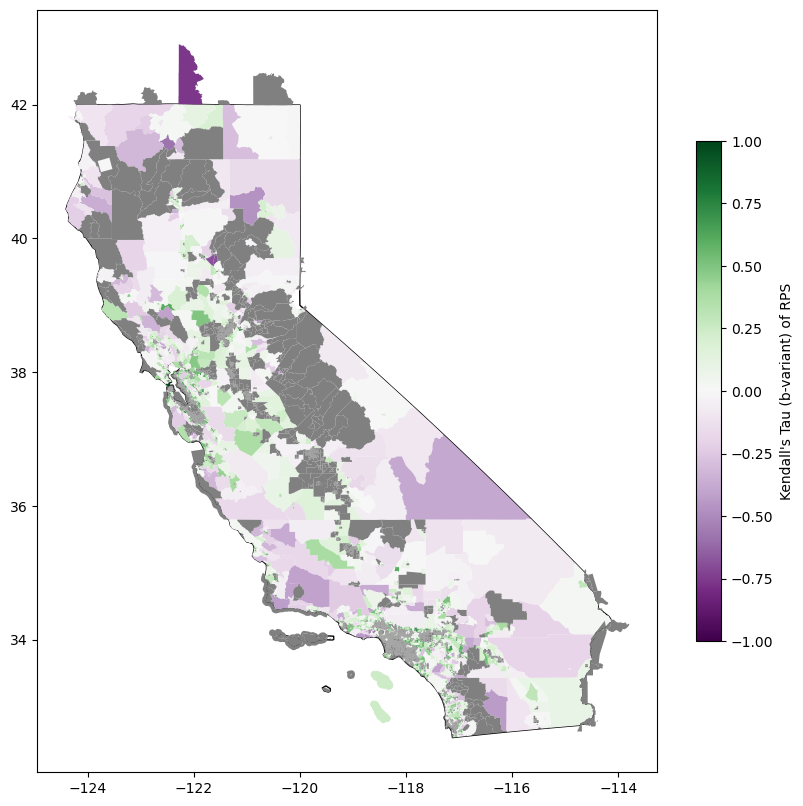

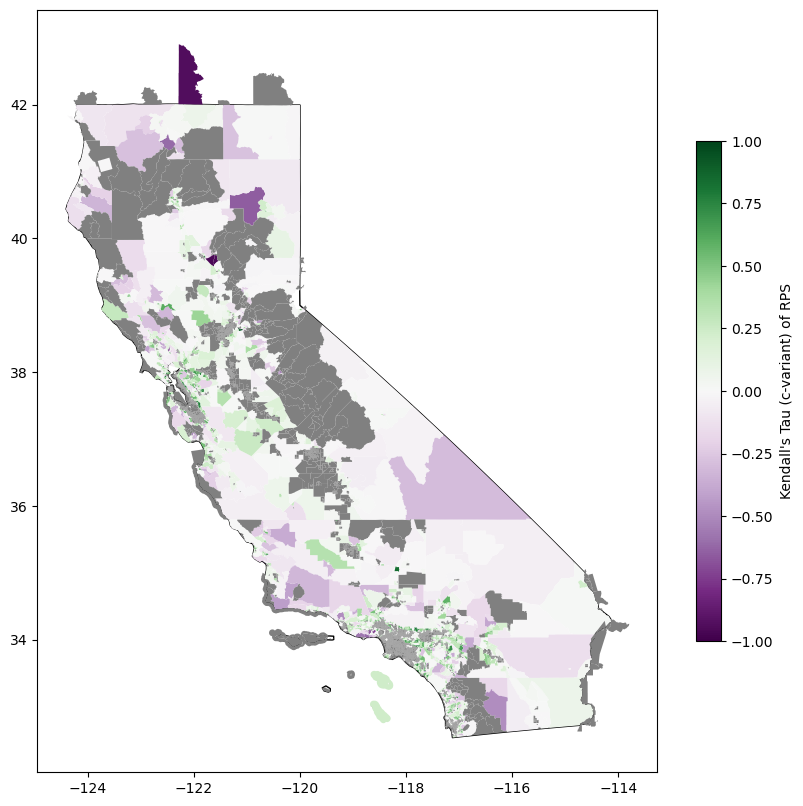

In [27]:
for variable in ['tau_b', 'tau_c']:
    fig, axarr = plt.subplots(figsize=(10, 10))
    ca.plot(ax=axarr, color='white', edgecolor='black')
    ax = tract_performance_stats.plot(
        ax=axarr,
        column=variable,
        vmin=var_lims[variable][0],
        vmax=var_lims[variable][1],
        legend=True,
        cmap=cmaps[variable],
        legend_kwds={'shrink': 0.65, 'label': variable_name_dict[variable]},
    )
    tract_performance_stats[tract_performance_stats['tau_b'].isnull()].plot(ax=axarr, color='grey')

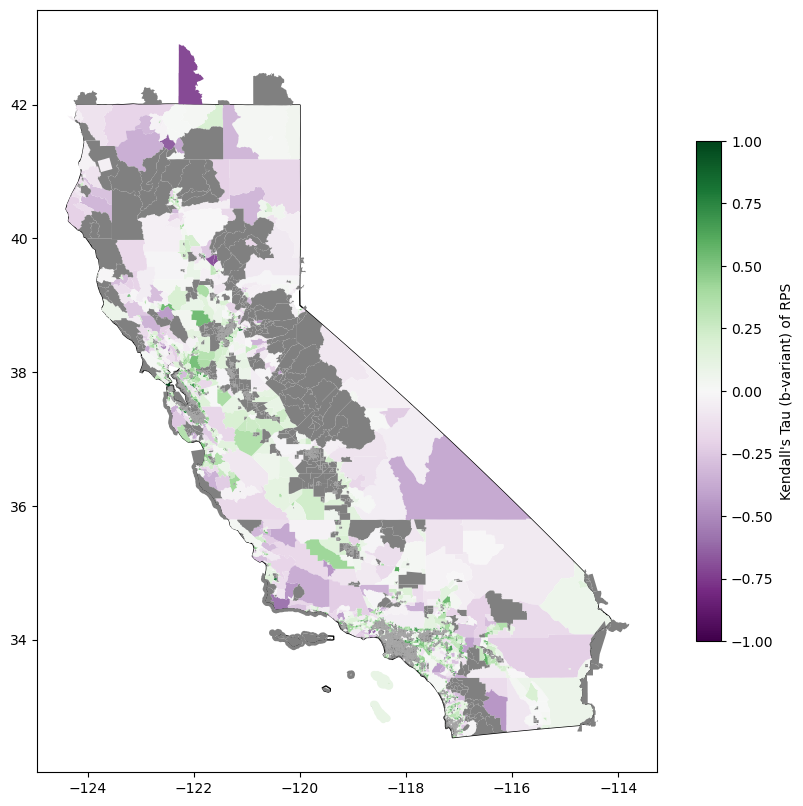

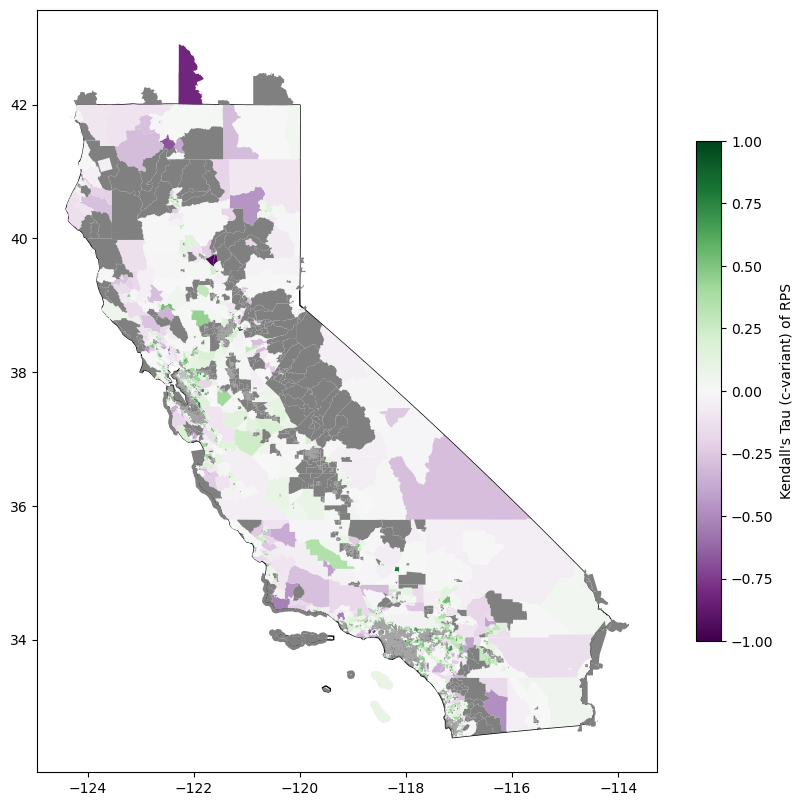

In [95]:
for variable in ['tau_b', 'tau_c']:
    fig, axarr = plt.subplots(figsize=(10, 10))
    ca.plot(ax=axarr, color='white', edgecolor='black')
    ax = tract_performance_stats.plot(
        ax=axarr,
        column=variable,
        vmin=var_lims[variable][0],
        vmax=var_lims[variable][1],
        legend=True,
        cmap=cmaps[variable],
        legend_kwds={'shrink': 0.65, 'label': variable_name_dict[variable]},
    )
    tract_performance_stats[tract_performance_stats['tau_b'].isnull()].plot(ax=axarr, color='grey')

In [5]:
scott2024 = catalog.get_dataset('USFS-wildfire-risk-communities-4326').to_xarray()

In [8]:
scott2024_buildlings = scott2024.sel(
    latitude=xr.DataArray(coords[:, 1], dims='building'),
    longitude=xr.DataArray(coords[:, 0], dims='building'),
    method='nearest',
)

In [11]:
ca_buildings['scott2024-RPS'] = scott2024_buildlings.RPS.values[0]

In [92]:
import geopandas as gpd
from shapely.geometry import Point

# Example: building_hazard is your xarray dataset with dims 'building'
lons = building_hazard.longitude.values
lats = building_hazard.latitude.values

# Create Point geometries
geometry = [Point(lon, lat) for lon, lat in zip(lons, lats)]

# Create GeoDataFrame, optionally add other data columns
gdf = gpd.GeoDataFrame({'hazard': building_hazard.values[0]}, geometry=geometry, crs='EPSG:4326')